In [1]:
!pip install git+https://github.com/fastai/fastai.git &> /dev/null

In [2]:
from fastai.vision.all import *

## 01:09:09 - Regression (cont next notebook)

* Will learn how to "invent" applications using DataBlock
* Image regression: for an image, return some kinda of continuous value (age prediction is one example)
* In this example, use [Biwi Kinect Head Pose Dataset](https://www.kaggle.com/kmader/biwi-kinect-head-pose-database) to find the centre of a person's face.

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
Path.BASE_PATH = path

* 24 directories, each corresponding to person photographed.

In [5]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
img_files = get_image_files(path)

* The label is a text file with the pose data. The filenames are the same as the first part of the image file name, ending in `pose.txt`

In [7]:
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

In [8]:
img2pose(img_files[0])

Path('22/frame_00163_pose.txt')

In [9]:
open(img2pose(img_files[0])).read()

'0.749067 0.0670679 0.659091 \n-0.248083 0.950873 0.185191 \n-0.614292 -0.30223 0.728905 \n\n-16.8291 56.2149 1048.09 \n\n'

* Fastai way to create PIL image is `PILImage.create`

In [10]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

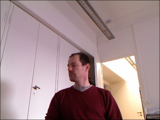

In [11]:
im.to_thumb(160)

* Note that in computer vision the dimensions are columns by rows. 
* This function gets the head centre point:

In [12]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [13]:
get_ctr(img_files[0])

tensor([311.6877, 268.2660])

* That function can be passed to `get_y` which labels each item

In [14]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240, 320)),
                Normalize.from_stats(*imagenet_stats)]
)

* Note that the validation set is an entire person. To enure that we don't trick ourselves into thinking we're generalising better than we are.
* `FuncSplitter` allows you to split with a function.
* `Normalize` subtracts the mean and divides by std.

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


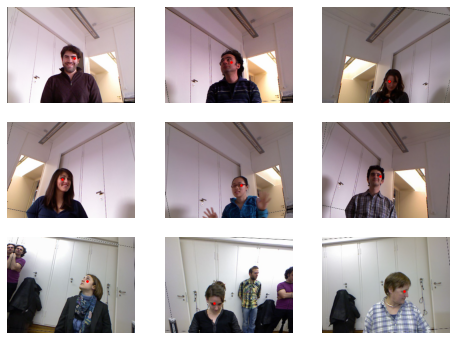

In [15]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8, 6))

In [16]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

* Coordinates is a [1, 2] tensor (a single point).

## 01:16:47 - Image channels

* A colour picture is a rank-3 tensor. First axis is channels: red, green and blue.

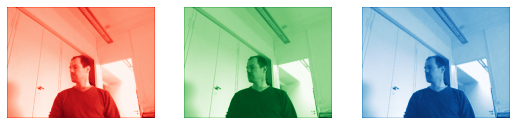

In [17]:
im = image2tensor(PILImage.create(img_files[0]))
_, axs = subplots(1, 3)
for chan, ax, colour in zip(im, axs, ('Reds', 'Greens', 'Blues')):
    show_image(255-chan, ax=ax, cmap=colour)

* A mini-batch of images is a rank-4 tensor.

## 01:17:45 - Training image regression model

* When we create a learner, we pass `y_range` which forces a range of targets.

```
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo
```

In [18]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 01:19:14 - Question: can you have more than 3 channels as input?

* Yes. Though pretrained models will need some changes to support this (copying layers for example)

## 01:20:13 - Training cont

* No loss function specified. fastai provides MSE by default for regression

In [19]:
dls.loss_func

FlattenedLoss of MSELoss()

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0014454397605732083)

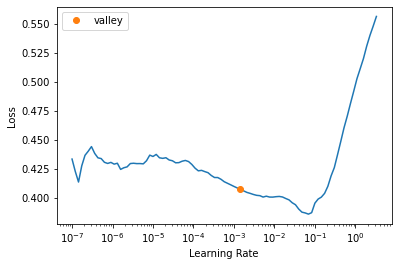

In [20]:
learn.lr_find()

In [21]:
lr = 0.002
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.124658,0.013659,01:53


epoch,train_loss,valid_loss,time
0,0.008415,0.000719,01:57
1,0.003397,0.000567,01:59
2,0.002295,0.000105,01:56


* Since it's squared error, we can get the square root to find average coord prediction error:

In [22]:
math.sqrt(0.000122)

0.01104536101718726

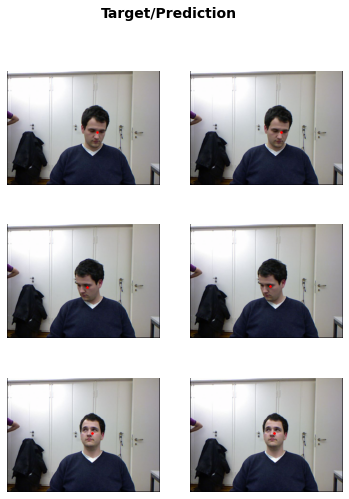

In [23]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))